# Preamble

In [1]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
import petpal.kinetic_modeling.graphical_analysis as pet_grph
import petpal.kinetic_modeling.parametric_images as pet_pim
import nibabel
import json
from importlib import reload

sns.set()
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.6)
plt.rcParams['font.family'] ='StixGeneral'
plt.rcParams['mathtext.fontset'] = 'stix'

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


$$\require{mchem}$$

# Loading Data & Resampling Plasma TAC (pTAC)

## Loading In A 4D-PET Image

In [2]:
DATA_DIR = '../../../../PracticeData/'

In [3]:
pet_img = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_FDG_on_mpr.nii.gz")

In [4]:
type(pet_img)

nibabel.nifti1.Nifti1Image

In [5]:
img_vals = pet_img.get_fdata()/37000.
xDim, yDim, zDim, tDim = img_vals.shape
img_vals.shape

(176, 240, 256, 52)

## Loading Arterial Input Function

In [6]:
arterial_input_function = np.loadtxt(f"{DATA_DIR}BloodData_CMS/1179307_v2.csv", skiprows=1, delimiter=',')

aif_tac   = np.array([arterial_input_function[:,1], arterial_input_function[:,-1]], 
                                   order="C", dtype='float')

aif_tac

array([[3.73330e-06, 2.16670e-01, 3.83340e-01, 6.66670e-01, 8.83340e-01,
        1.05000e+00, 1.25000e+00, 1.41670e+00, 1.60000e+00, 1.78330e+00,
        2.03334e+00, 2.18334e+00, 2.31667e+00, 2.46667e+00, 2.61667e+00,
        2.85000e+00, 3.06667e+00, 3.33334e+00, 3.58334e+00, 3.81667e+00,
        4.08334e+00, 4.33334e+00, 4.58334e+00, 4.83334e+00, 5.33334e+00,
        5.75000e+00, 6.70000e+00, 7.71667e+00, 8.71667e+00, 9.70000e+00,
        1.07000e+01, 1.27000e+01, 1.57000e+01, 2.06500e+01, 2.56500e+01,
        3.06500e+01, 3.56500e+01, 4.56500e+01, 6.06500e+01],
       [6.22500e-05, 6.75620e-05, 1.21810e+00, 2.21840e+00, 8.36830e-01,
        6.13820e-01, 5.24330e-01, 4.76340e-01, 4.65450e-01, 4.67900e-01,
        4.70964e-01, 4.30692e-01, 4.55850e-01, 4.38788e-01, 4.30899e-01,
        4.23412e-01, 4.02504e-01, 3.87883e-01, 3.87879e-01, 3.80343e-01,
        3.71751e-01, 3.61616e-01, 3.59765e-01, 3.55952e-01, 3.46931e-01,
        3.35135e-01, 3.19147e-01, 3.09760e-01, 2.94450e-01, 2.8

### Plotting pTAC

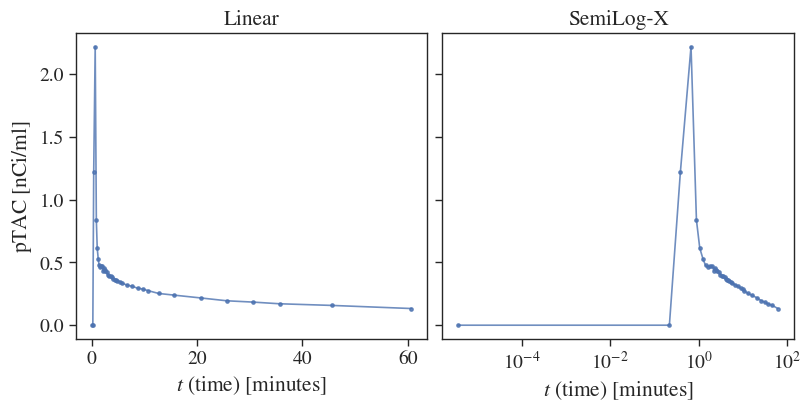

In [7]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, '.-', alpha=0.8)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')

plt.show()

## Resampling pTAC At Scanner Frame Times

### Loading In Scanner Frame Times

In [8]:
scanner_times = []
with open("../../../../PracticeData/ScannerFrameTimes_CMS/1179307_v2_info.json") as dFile:
    scanner_times = np.array(json.load(dFile)['FrameReferenceTime'], order='C', dtype=float)/60.
scanner_times

array([2.49981667e-02, 1.08331500e-01, 1.91665000e-01, 2.74998333e-01,
       3.58331667e-01, 4.41665000e-01, 5.24998333e-01, 6.08331667e-01,
       6.91665000e-01, 7.74998333e-01, 8.58331667e-01, 9.41665000e-01,
       1.02499833e+00, 1.10833167e+00, 1.19166500e+00, 1.27499833e+00,
       1.35833167e+00, 1.44166500e+00, 1.52499833e+00, 1.60833167e+00,
       1.69166667e+00, 1.77500000e+00, 1.85833333e+00, 1.94166667e+00,
       2.14996667e+00, 2.48330000e+00, 2.81663333e+00, 3.14996667e+00,
       3.48330000e+00, 3.81663333e+00, 4.14996667e+00, 4.48330000e+00,
       4.81663333e+00, 5.48306667e+00, 6.48306667e+00, 7.48306667e+00,
       8.48306667e+00, 9.48306667e+00, 1.04830667e+01, 1.14830667e+01,
       1.24830667e+01, 1.34830667e+01, 1.44830667e+01, 1.74768333e+01,
       2.24768333e+01, 2.74768333e+01, 3.24768333e+01, 3.74768333e+01,
       4.24768333e+01, 4.74768333e+01, 5.24768333e+01, 5.74768333e+01])

### Interpolating pTAC On Scanner Frame Times

In [9]:
from petpal.input_function.blood_input import BloodInputFunction

In [11]:
scanner_aif = BloodInputFunction(time=aif_tac[0], activity=aif_tac[1], thresh_in_mins=30.0)
aif_on_scanner_tac = np.array([scanner_times, scanner_aif.calc_blood_input_function(t=scanner_times)],
                           dtype=float, order='C')

### Plotting Resampled pTAC

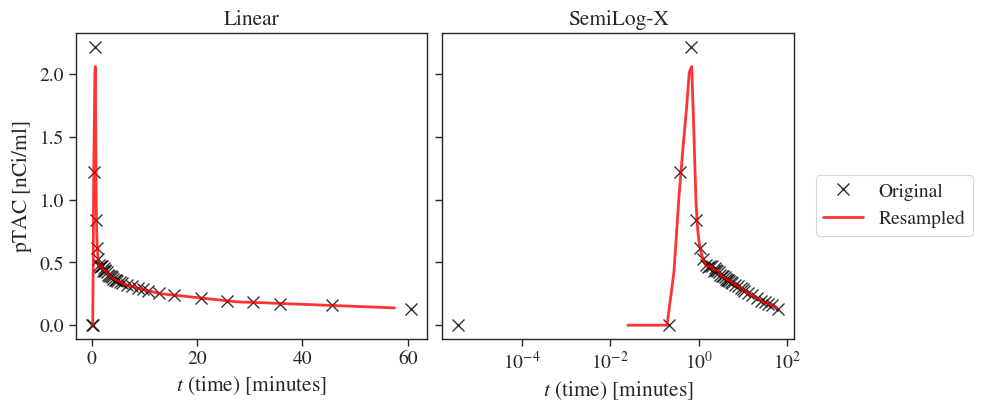

In [12]:
myFig, myAx = plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*aif_tac, 'x', alpha=0.8, label='Original', color='black', ms=8)
    anAx.plot(*aif_on_scanner_tac, '-', alpha=0.8, label='Resampled', color='red', lw=2)
    anAx.set(xlabel=r'$t$ (time) [minutes]')
    
    

myAx[0].set(ylabel=r'pTAC [$\mathrm{n Ci / ml}$]', title='Linear')
myAx[1].set(xscale='log', title='SemiLog-X')
myFig.legend(*myAx[0].get_legend_handles_labels(), bbox_to_anchor=(1.0, 0.5), loc='center left')

plt.show()

### Saving Resampled pTAC To File

In [13]:
np.savetxt(fname="../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt", 
           X=aif_on_scanner_tac.T,
          header='Time (s), Activity (nCu)', fmt='%.6e')

# Generating Parametric Images: Explicitly Looping Over All Voxels

## Reusing `patlak_analysis` from `graphical_analysis`

In [14]:
@numba.njit()
def gen_patlak_parametric_image(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_vals = pet_grph.patlak_analysis(input_tac_values=pTAC_vals, 
                                                       region_tac_values=tTAC_img[i,j,k,:],
                                                       tac_times_in_minutes=pTAC_times,
                                                       t_thresh_in_minutes=t_thresh_in_mins)
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, 
                                                              yDim//2-10:yDim//2+10, 
                                                              zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [15]:
# %%timeit
tmp_param_imgs = gen_patlak_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

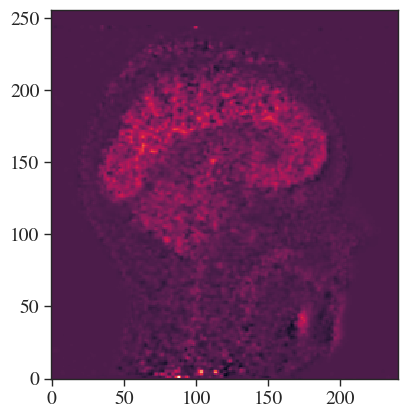

In [16]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

## Testing New Implementation To Take Out Redundant Patlak-X Calculations

In [17]:
@numba.njit()
def gen_patlak_parametric_image_v2(pTAC_times: np.ndarray, pTAC_vals: np.ndarray,
                                tTAC_img, t_thresh_in_mins: float) -> np.ndarray:
    img_dims = tTAC_img.shape
    
    patlak_ki_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    patlak_vt_img = np.zeros_like(patlak_ki_img)
    
    t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=pTAC_times, 
                                        t_thresh_in_minutes=t_thresh_in_mins)
    
    patlak_x = pet_grph.calculate_patlak_x(tac_times=pTAC_times, tac_vals=pTAC_vals)
    
    inv_pTAC_vals = 1.0/pTAC_vals[:]
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                patlak_y = tTAC_img[i,j,k,:]*inv_pTAC_vals[:]
                patlak_vals = pet_grph.fit_line_to_data_using_lls(xdata=patlak_x[t_thresh:], 
                                                                  ydata=patlak_y[t_thresh:])
                patlak_ki_img[i,j,k]=patlak_vals[0]
                patlak_vt_img[i,j,k]=patlak_vals[1]
    return patlak_ki_img, patlak_vt_img

tmp_param_imgs = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim//2-10:xDim//2+10, yDim//2-10:yDim//2+10, zDim//2-10:zDim//2+10, :],
                                            t_thresh_in_mins=30.0)

In [18]:
# %%timeit
tmp_param_imgs_v2 = gen_patlak_parametric_image_v2(pTAC_times=aif_on_scanner_tac[0],
                                             pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

In [19]:
plt.imshow(tmp_param_imgs[0][xDim//2,:,:].T, interpolation='none', origin='lower')
plt.show()

IndexError: index 88 is out of bounds for axis 0 with size 20

In [ ]:
np.allclose(tmp_param_imgs[0] - tmp_param_imgs_v2[0], 0.0)

## Testing The Logan Analysis By Reusing `logan_analysis` from `graphical_analysis`

In [ ]:
from typing import Tuple
@numba.njit()
def gen_logan_parametric_image(pTAC_times: np.ndarray,
                               pTAC_vals: np.ndarray,
                               tTAC_img,
                               t_thresh_in_mins: float) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    logan_slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    logan_intercept_img = np.zeros_like(logan_slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                logan_vals = pet_grph.logan_analysis(input_tac_values=pTAC_vals,
                                                     region_tac_values=tTAC_img[i, j, k, :],
                                                     tac_times_in_minutes=pTAC_times,
                                                     t_thresh_in_minutes=t_thresh_in_mins)
                logan_slope_img[i, j, k] = logan_vals[0]
                logan_intercept_img[i, j, k] = logan_vals[1]
    return logan_slope_img, logan_intercept_img


tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0], 
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals[xDim // 2 - 10:xDim // 2 + 10,
                                                              yDim // 2 - 10:yDim // 2 + 10, 
                                                              zDim // 2 - 10:zDim // 2 + 10, :],
                                            t_thresh_in_mins=30.0)

In [ ]:
print(img_vals.max())
print(img_vals.min())

In [ ]:
tmp_param_imgs = gen_logan_parametric_image(pTAC_times=aif_on_scanner_tac[0],
                                            pTAC_vals=aif_on_scanner_tac[1],
                                            tTAC_img=img_vals,
                                            t_thresh_in_mins=30.0)

We will have to add some division by 0 checks in the logan analysis to circumvent this problem

## Testing A Template-Like Function

In [ ]:
from typing import Tuple
@numba.njit()
def gen_parametric_image_with_graphical_method(pTAC_times: np.ndarray,
                                               pTAC_vals: np.ndarray,
                                               tTAC_img: np.ndarray,
                                               t_thresh_in_mins: float,
                                               analysis_func) -> Tuple[np.ndarray, np.ndarray]:
    img_dims = tTAC_img.shape
    
    slope_img = np.zeros((img_dims[0], img_dims[1], img_dims[2]), float)
    intercept_img = np.zeros_like(slope_img)
    
    for i in range(0, img_dims[0], 1):
        for j in range(0, img_dims[1], 1):
            for k in range(0, img_dims[2], 1):
                analysis_vals = analysis_func(input_tac_values=pTAC_vals, 
                                              region_tac_values=tTAC_img[i, j, k, :],
                                              tac_times_in_minutes=pTAC_times,
                                              t_thresh_in_minutes=t_thresh_in_mins)
                slope_img[i, j, k] = analysis_vals[0]
                intercept_img[i, j, k] = analysis_vals[1]
    return slope_img, intercept_img

In [ ]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

### Plotting A Histogram Of Slope ($K_1$) Values Over The Brain

In [ ]:
brain_mask = nibabel.load(f"{DATA_DIR}/4DPET/1179307_v2_mpr_BET_mask.nii.gz").get_fdata()

In [ ]:
plt.hist((tmp_patlak_img[0]*brain_mask).flatten(), density=True, bins=np.linspace(-0.1, 0.2, 25))
plt.yscale('log')
plt.show()

# Comparing Test Implementation With Package Implementation

In [ ]:
tmp_patlak_img = gen_parametric_image_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            analysis_func=pet_grph.patlak_analysis)

In [ ]:
tmp_patlak_img_new = pet_pim.generate_parametric_images_with_graphical_method(pTAC_times=aif_on_scanner_tac[0],
                                                            pTAC_vals=aif_on_scanner_tac[1],
                                                            tTAC_img=img_vals,
                                                            t_thresh_in_mins=30.0,
                                                            method_name='patlak')

In [ ]:
np.allclose(tmp_patlak_img[0] - tmp_patlak_img_new [0], 0.0)

# Testing Writing Parametric Images Using The Class

In [ ]:
from importlib import reload
reload(pet_pim)
reload(pet_grph)

In [ ]:
patlak_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')

In [ ]:
patlak_pim.run_analysis(method_name='patlak', t_thresh_in_mins=30.0)

In [ ]:
patlak_pim.save_parametric_images()
patlak_pim.save_analysis_properties()

# Testing Calculating $R^2$-Values For Simple TACs

## Loading And Plotting

In [ ]:
pTAC = pet_pim._safe_load_tac(filename='../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt')
tTAC = pet_pim._safe_load_tac(filename='../../data/tcm_tacs/serial_2tcm_k4zero/gaussian_noise/tac_2tcm_k4zero_set-01.txt')
myFig, myAx =plt.subplots(1,2, constrained_layout=True, figsize=[8,4], sharey=True)
for anAx in myAx.flatten():
    anAx.plot(*pTAC, 'x-', label='pTAC', color='k')
    anAx.plot(*tTAC, '.-', label='tTAC')
    
myAx[0].set(title='Linear', ylabel='Activity [nCi/ml]', xlabel='time [mins]')
myAx[1].set(title='Semi-LogX', ylabel='Activity [nCi/ml]', xlabel='time [mins]', xscale='log')
myFig.legend(*myAx.flatten()[0].get_legend_handles_labels(), bbox_to_anchor=(1.0,0.5), loc='center left')
plt.show()

In [ ]:
patlak_x = pet_grph.calculate_patlak_x(*pTAC)
patlak_y = tTAC[1]/pTAC[1]
plt.plot(patlak_x, patlak_y)
plt.show()

## Calculating The $R^2$-Value

In [ ]:
@numba.njit()
def fit_line_to_data_using_lls_with_rsquared(xdata: np.ndarray, ydata: np.ndarray) -> np.ndarray:
    make_2d_matrix = pet_grph._line_fitting_make_rhs_matrix_from_xdata
    matrix = make_2d_matrix(xdata)
    fit_ans = np.linalg.lstsq(matrix, ydata)
    
    ss_res = fit_ans[1][0]
    ss_tot = np.sum((np.mean(ydata)-ydata)**2.)
    r_squared = 1.0 - ss_res/ss_tot
    return fit_ans[0][0], fit_ans[0][1], r_squared

In [ ]:
patlak_x = pet_grph.calculate_patlak_x(*pTAC)
fit_line_to_data_using_lls_with_rsquared(xdata=patlak_x[-200:], ydata=tTAC[1][-200:]/pTAC[1][-200:])

## Testing Implementation Of Saving Analysis Properties From TACs

In [ ]:
reload(pet_pim)
reload(pet_grph)

In [ ]:
tacs_obj = pet_grph.GraphicalAnalysis(input_tac_path="../../data/tcm_tacs/fdg_plasma_clamp_evenly_resampled.txt",
                                     roi_tac_path="../../data/tcm_tacs/serial_2tcm_k4zero/gaussian_noise/tac_2tcm_k4zero_set-01.txt",
                                     output_directory="../../../../PracticeData/4DPET/",
                                     output_filename_prefix='test')

In [ ]:
tacs_obj.run_analysis(method_name='logan', t_thresh_in_mins=30.0)

In [ ]:
tacs_obj.save_analysis()

# Prototyping Fixing Logan Analysis Division By 0

## Re-creating Bug

In [ ]:
reload(pet_pim)
reload(pet_grph)

In [ ]:
pet_img = nibabel.load(f"../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz")
img_vals = pet_img.get_fdata()/37000.
xDim, yDim, zDim, tDim = img_vals.shape
img_vals.shape

In [ ]:
aif_on_scanner = pet_grph._safe_load_tac('../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt')

In [ ]:
tmp_logan_img_new = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')

In [ ]:
tmp_logan_img_new.run_analysis(method_name='logan', t_thresh_in_mins=40.0)

## Finding Voxels That Fail

In [ ]:
img_vals.shape

In [ ]:
step_size = 1
img_num_zeros = np.zeros((xDim//step_size, yDim//step_size, zDim//step_size), dtype=float)
for i, x_slice in enumerate(img_vals[::step_size]):
    for j, y_slice in enumerate(x_slice[::step_size]):
        for k, t_tac in enumerate(y_slice[::step_size]):
            img_num_zeros[i,j,k] = len(np.argwhere(t_tac==0).T[0])
#             print((i*100,j*100,k*100), len(np.argwhere(t_tac==0).T[0]))
#             print((i*100,j*100,k*100), np.argwhere(t_tac==0).T)

In [ ]:
myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))
myAx.hist(img_num_zeros.flatten(), density=True, bins=np.linspace(0-1, 52+1, 52))
plt.ylabel(r"$P_n(tTAC=0)$")
plt.xlabel(r"$n$ (Number Of 0s in tTAC)")
myFig.suptitle("tTACs Have Lots Of 0s\nIn A Bi-Modal Distribution", ha='center', va='top')
plt.show()

In [ ]:
myFig, myAx = plt.subplots(1,1, constrained_layout=True, figsize=(5,5))
myAx.hist(img_num_zeros.flatten(), density=True, bins=np.linspace(0-1, 52+1, 52), cumulative=True)
plt.ylabel(r"$CDF(P_n(tTAC=0))$")
plt.xlabel(r"$n$ (Number Of 0s in tTAC)")
myFig.suptitle("tTACs Have Lots Of 0s\nIn A Bi-Modal Distribution", ha='center', va='top')
plt.show()

### Getting The Voxles With $\leq 5$ 0's and $\geq 40$ 0's

In [ ]:
voxel_ids_with_at_most_5_zeros = np.argwhere(img_num_zeros <= 5)
voxel_ids_with_at_most_5_zeros = np.argwhere(img_num_zeros <= 5)
voxel_ids_with_at_most_5_zeros.shape

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    plt.plot(pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=img_vals[an_id[0],an_id[1],an_id[2]]),
            '.-')
plt.yscale('log')
plt.show()

In [ ]:
voxel_ids_with_at_least_40_zeros = np.argwhere(img_num_zeros >= 40)
voxel_ids_with_at_least_40_zeros = np.argwhere(img_num_zeros >= 40)
voxel_ids_with_at_least_40_zeros.shape

In [ ]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    plt.plot(pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=img_vals[an_id[0],an_id[1],an_id[2]]),
            '.-')
plt.yscale('log')
plt.show()

## Plotting The Logan $X$ And $Y$ For Bad TACs

### With At Most 5 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    plt.plot(logan_x, logan_y, '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### Plotting True Logan $X$ and $Y$

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    logan_x /= t_tac
    logan_y /= t_tac
    
    plt.plot(logan_x, logan_y, '.')

# plt.yscale('log')
plt.ylim(0,200)
plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

### With At Least 40 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

In [ ]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    plt.plot(logan_x, logan_y, '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### Plotting True Logan $X$ and $Y$

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    logan_x /= t_tac
    logan_y /= t_tac
    
    plt.plot(logan_x, logan_y, '.-', mec='k', alpha=0.8)

# plt.yscale('log')
plt.ylim(0,200)
plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

## Simply Ignoring The 0s For Calculations

### With At Most 5 0's

#### Not-Dividing By $R(t)$ (Plotting $R(t)\cdot X$ and $R(t)\cdot Y$)

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)
    
    good_points = np.argwhere(t_tac != 0.).T[0]
    
    
    plt.plot(logan_x[good_points], logan_y[good_points], '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### True Logan Plots

In [ ]:
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)
    
    good_points = np.argwhere(t_tac != 0.).T[0]
    print(good_points)
    logan_x = logan_x[good_points] / t_tac[good_points]
    logan_y = logan_y[good_points] / t_tac[good_points]
    
    plt.plot(logan_x, logan_y, '.', alpha=0.8)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,200)
# plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

### With At Least 40 0's

#### Just The Cumulative Integrals

In [ ]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    good_points = np.argwhere(t_tac != 0.).T[0]
    
    
    plt.plot(logan_x[good_points], logan_y[good_points], '.-')

plt.yscale('log')

plt.ylabel(r"$\int_{0}^{t}R(s)\mathrm{d}s$")
plt.xlabel(r"$\int_{0}^{t}C(s)\mathrm{d}s$")
plt.show()

#### True Logan Plots

In [ ]:
for an_id in voxel_ids_with_at_least_40_zeros[::1000000//10]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=aif_on_scanner[1])
    logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], ydata=t_tac)

    good_points = np.argwhere(t_tac != 0.).T[0]
    print(good_points)
    logan_x = logan_x[good_points] / t_tac[good_points]
    logan_y = logan_y[good_points] / t_tac[good_points]
    
    plt.plot(logan_x, logan_y, '.-', mec='k', alpha=0.8)

plt.yscale('log')
plt.xscale('log')
# plt.ylim(0,200)
# plt.xlim(0,1000)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.show()

## Combining `good_points` With A `t_thresh` Calculation For Full Logan Analysis

### TACs With Less Than 5 Zeroes

In [ ]:
myFig, myAx = plt.subplots(1, 1, figsize=[5,5], constrained_layout=True)
for an_id in voxel_ids_with_at_most_5_zeros[::1000000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    good_points = np.argwhere(t_tac != 0.).T[0]
#     print(f"Len GP:= {len(good_points)}")
    if len(good_points) <= 2:
        slope, intercept = np.nan, np.nan
    else:
        t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=aif_on_scanner[0][good_points], 
                                                    t_thresh_in_minutes=40.0)
#         print(f"Len TH:= {len(t_tac[good_points][t_thresh:])}")
        if len(t_tac[good_points][t_thresh:]) <= 2:
            slope, intercept = np.nan, np.nan
        else:
#             print("Enough points")
            logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], 
                                                               ydata=aif_on_scanner[1])
            logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], 
                                                               ydata=t_tac)

            logan_x = logan_x[good_points][t_thresh:] / t_tac[good_points][t_thresh:]
            logan_y = logan_y[good_points][t_thresh:] / t_tac[good_points][t_thresh:]

            fit_ans = pet_grph.fit_line_to_data_using_lls(xdata=logan_x, ydata=logan_y)
            slope, intercept = fit_ans[0], fit_ans[1]

            plt.plot(logan_x, logan_y, '.-', alpha=0.8, label=f'm={slope:>5.2e}; b={intercept:>5.2e}')

plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-1,1e8)
# plt.xlim(1e-1,1e8)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

### TACs With More Than 40 Zeroes

In [ ]:
myFig, myAx = plt.subplots(1, 1, figsize=[5,5], constrained_layout=True)
for an_id in voxel_ids_with_at_least_40_zeros[::100000//2]:
    t_tac = img_vals[an_id[0], an_id[1], an_id[2]]
    good_points = np.argwhere(t_tac != 0.).T[0]
#     print(f"Len GP:= {len(good_points)}")
    if len(good_points) <= 2:
        slope, intercept = np.nan, np.nan
    else:
        t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=aif_on_scanner[0][good_points], 
                                                    t_thresh_in_minutes=40.0)
#         print(f"Len TH:= {len(t_tac[good_points][t_thresh:])}")
        if len(t_tac[good_points][t_thresh:]) <= 2:
            slope, intercept = np.nan, np.nan
        else:
#             print("Enough points")
            logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], 
                                                               ydata=aif_on_scanner[1])
            logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=aif_on_scanner[0], 
                                                               ydata=t_tac)

            logan_x = logan_x[good_points][t_thresh:] / t_tac[good_points][t_thresh:]
            logan_y = logan_y[good_points][t_thresh:] / t_tac[good_points][t_thresh:]

            fit_ans = pet_grph.fit_line_to_data_using_lls(xdata=logan_x, ydata=logan_y)
            slope, intercept = fit_ans[0], fit_ans[1]

            plt.plot(logan_x, logan_y, '.-', alpha=0.8, label=f'm={slope:>5.2e}; b={intercept:>5.2e}')

plt.yscale('log')
plt.xscale('log')
# plt.ylim(1e-1,1e8)
# plt.xlim(1e-1,1e8)
plt.ylabel(r"$\frac{\int_{0}^{t}R(s)\mathrm{d}s}{R(t)}$", fontsize=24)
plt.xlabel(r"$\frac{\int_{0}^{t}C(s)\mathrm{d}s}{R(t)}$", fontsize=24)
myFig.legend(bbox_to_anchor=(1.0, 0.5), loc='center left')
plt.show()

## Combining To Make A New Function That Iterates Over All Voxels To Generate A Slope Image And An Intercept Image

In [ ]:
from typing import Tuple
import numba
@numba.njit
def smart_logan_analysis(input_tac_values: np.ndarray,
                         region_tac_values: np.ndarray,
                         tac_times_in_minutes: np.ndarray,
                         t_thresh_in_minutes: float) -> np.ndarray:
    
    good_points = np.argwhere(region_tac_values != 0.).T[0]
    if len(good_points) <= 2:
        return np.asarray([np.nan, np.nan])
    else:
        t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=tac_times_in_minutes[good_points], 
                                                     t_thresh_in_minutes=t_thresh_in_minutes)
        if len(tac_times_in_minutes[good_points][t_thresh:]) <= 2:
            return np.asarray([np.nan, np.nan])
        else:
            logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=tac_times_in_minutes, 
                                                               ydata=input_tac_values)
            logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=tac_times_in_minutes, 
                                                               ydata=region_tac_values)

            logan_x = logan_x[good_points][t_thresh:] / region_tac_values[good_points][t_thresh:]
            logan_y = logan_y[good_points][t_thresh:] / region_tac_values[good_points][t_thresh:]

            fit_ans = pet_grph.fit_line_to_data_using_lls(xdata=logan_x, ydata=logan_y)
            return fit_ans
        
@numba.njit()
def smart_alt_logan_analysis(input_tac_values: np.ndarray,
                         region_tac_values: np.ndarray,
                         tac_times_in_minutes: np.ndarray,
                         t_thresh_in_minutes: float) -> np.ndarray:
    
    good_points = np.argwhere(region_tac_values != 0.).T[0]
    if len(good_points) <= 2:
        return np.asarray([np.nan, np.nan])
    else:
        t_thresh = pet_grph.get_index_from_threshold(times_in_minutes=tac_times_in_minutes[good_points], 
                                                     t_thresh_in_minutes=t_thresh_in_minutes)
        if len(tac_times_in_minutes[good_points][t_thresh:]) <= 2:
            return np.asarray([np.nan, np.nan])
        else:
            logan_x = pet_grph.cumulative_trapezoidal_integral(xdata=tac_times_in_minutes, 
                                                               ydata=input_tac_values)
            logan_y = pet_grph.cumulative_trapezoidal_integral(xdata=tac_times_in_minutes, 
                                                               ydata=region_tac_values)

            logan_x = logan_x[good_points][t_thresh:] / input_tac_values[good_points][t_thresh:]
            logan_y = logan_y[good_points][t_thresh:] / region_tac_values[good_points][t_thresh:]

            fit_ans = pet_grph.fit_line_to_data_using_lls(xdata=logan_x, ydata=logan_y)
            return fit_ans

In [ ]:
param_images = pet_pim.apply_linearized_analysis_to_all_voxels(pTAC_times=aif_on_scanner[0],
                                                               pTAC_vals=aif_on_scanner[1],
                                                               tTAC_img=img_vals,
                                                               t_thresh_in_mins=30.0,
                                                               analysis_func=pet_grph.patlak_analysis)

In [ ]:
dumI0, dumJ0, dumK0 = np.argwhere(np.isfinite(param_images[0])).T
dumI1, dumJ1, dumK1 = np.argwhere(np.isfinite(param_images[1])).T

In [ ]:
print(np.max(param_images[0][dumI0, dumJ0, dumK0]), np.min(param_images[0][dumI0, dumJ0, dumK0]))
print(np.max(param_images[1][dumI1, dumJ1, dumK1]), np.min(param_images[1][dumI1, dumJ1, dumK1]))

In [ ]:
myFig, myAx = plt.subplots(3,3, sharex=True, sharey=True, constrained_layout=True, dpi=150)
for axID, anAx in enumerate(myAx.flatten()):
    cBar = anAx.imshow(param_images[0][xDim//2-5*5 + 5*axID, :, :].T, interpolation='none', origin='lower',
               vmin=-0.15/4, vmax=0.15/4, cmap='bwr')
cAx = plt.colorbar(cBar, ax=myAx)
cAx.set_label("Logan Slope", rotation=270)
plt.show()

In [ ]:
myFig, myAx = plt.subplots(3,3, sharex=True, sharey=True, constrained_layout=True, dpi=150)
for axID, anAx in enumerate(myAx.flatten()):
    cBar = anAx.imshow(param_images[1][xDim//2-5*5 + 5*axID, :, :].T, 
                       interpolation='none', origin='lower',
                       vmin=-6.62/4, vmax=6.62/4, cmap='bwr')
cAx = plt.colorbar(cBar, ax=myAx)
cAx.set_label("Logan Intercept",
              rotation=270)
plt.show()

## Testing Package Implementation To Make Logan Parametric Images

### Patlak Image

In [2]:
patlak_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')
patlak_pim.run_analysis(method_name='patlak', t_thresh_in_mins=30.0)
patlak_pim.save_parametric_images()
patlak_pim.save_analysis_properties()

/Users/furqandar/Library/Python/3.9/lib/python/site-packages/petpal/kinetic_modeling/parametric_images.py:432: UserWarning:

PET image values are being divided by 37000 for unit conversion to Bq/cc.



An IOError occurred while attempting to write the NIfTI image files.


FileNotFoundError: Metadata file /Users/furqandar/Desktop/Work/BrierLab/PracticeData/4DPET/1179307_v2_FDG_on_mpr.json not found. Does it have a different path?

### Logan Image

In [ ]:
logan_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')
logan_pim.run_analysis(method_name='logan', t_thresh_in_mins=30.0)
logan_pim.save_parametric_images()
logan_pim.save_analysis_properties()

### Alt Logan Image

In [ ]:
alt_logan_pim = pet_pim.GraphicalAnalysisParametricImage(input_tac_path='../../../../PracticeData/4DPET/1179307_v2_pTAC_resampled_on_scanner_times.txt',
                                                     pet4D_img_path='../../../../PracticeData/4DPET/1179307_v2_FDG_on_mpr.nii.gz',
                                                     output_directory='../../../../PracticeData/4DPET/',
                                                     output_filename_prefix='test')
alt_logan_pim.run_analysis(method_name='alt_logan', t_thresh_in_mins=30.0)
alt_logan_pim.save_parametric_images()
alt_logan_pim.save_analysis_properties()